In [1]:
import pylab
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## items imformation

In [2]:
df_items0 = pd.read_csv("DATA/DMC_2017_task/items.csv", sep = "|")
print(df_items0.shape)

del df_items0["campaignIndex"]
df_items0.pharmForm = df_items0.pharmForm.str.upper()

(22035, 11)


In [3]:
content = pd.DataFrame(df_items0.content.str.split('X',2).tolist(), columns = ['x','y','z'])
content = content.fillna('1')
content.x = pd.to_numeric(content.x, errors='coerce')
content.y = pd.to_numeric(content.y, errors='coerce')
content.z = pd.to_numeric(content.z, errors='coerce')
content['Content'] = content.x * content.y * content.z
df_items1 = pd.concat([df_items0, content], axis=1, join_axes=[df_items0.index])
del df_items1["x"]
del df_items1["y"]
del df_items1["z"]
del df_items1["content"]

df_items1.group = df_items1.group.astype("category").cat.codes
df_items1.unit = df_items1.unit.astype("category").cat.codes
df_items1.pharmForm = df_items1.pharmForm.astype("category").cat.codes
#df_items = pd.get_dummies(df_items)

df_items1.head()

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,1,1,529,7,135,0,40,NaN,10.89,80.0
1,2,1,529,7,135,0,40,NaN,10.89,80.0
2,3,1,529,1,45,0,40,NaN,16.45,10.0
3,4,1,529,7,135,0,40,NaN,10.89,80.0
4,5,2,74,7,112,0,40,1.0,22.53,8.0


content: 幾乘幾, pharmForm: 藥品型態, genericProduct: 是否為基因產品, salesIndex: 配送規則代碼, category: Main shop category, rrp: reference price

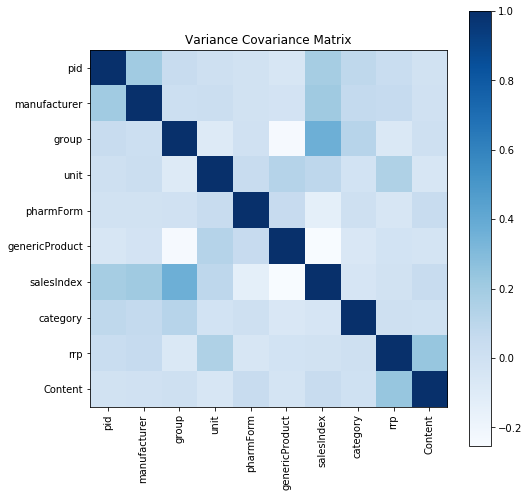

In [4]:
df_items1.corr()

plt.figure(num=None, figsize=(8, 8))
plt.imshow(df_items1.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_items1.columns))]
plt.xticks(tick_marks, df_items1.columns, rotation='vertical')
plt.yticks(tick_marks, df_items1.columns)
plt.title('Variance Covariance Matrix', fontsize = 12)

plt.show()

## feature extraction

In [5]:
def onehot1(df):
    onehot = np.array(pd.get_dummies(df))
    original_dim = onehot.shape[1]
    print('original dimension : %d' % onehot.shape[1])
    return onehot, original_dim

def onehot2(df):
    df_le = pd.DataFrame(np_utils.to_categorical(df,(max(df)+1)))
    original_dim = df_le.shape[1]
    print('original dimension : %d' % df_le.shape[1])
    return df_le, original_dim

def auto(df, dim):
    from keras.layers import Input, Dense
    from keras.models import Model
    from keras.callbacks import TensorBoard
    encoding_dim = dim

    input_img = Input(shape=(df.shape[1],))
    encoded = Dense(1000, activation='relu')(input_img)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(250, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(250, activation='relu')(decoded)
    decoded = Dense(500, activation='relu')(decoded)
    decoded = Dense(1000, activation='relu')(decoded)
    decoded = Dense(df.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input=input_img, output=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    history = autoencoder.fit(df, df,
                              nb_epoch = nb_epoch,
                              batch_size = 256,
                              shuffle = True,
                              validation_split=0.2)
    from keras import backend as K
    target_layer = K.function(autoencoder.inputs, [autoencoder.layers[4].output])
    ## Extract output from the target hidden layer.
    target_layer_out = target_layer([df])
    df_auto = pd.DataFrame(np.array(target_layer_out[0]))
    print('encoding dimension : %d' % (df_auto.shape[1]))
    return history, df_auto

def Plot(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)  
    plt.show()

def F1(x):
    df_onehot, original_dim = onehot1(x)
    df_his, df_auto = auto(df_onehot, int(original_dim/10))
    Plot(df_his.history['loss'], df_his.history['val_loss'], 'Loss')
    return df_auto

def F2(x):
    df_onehot, original_dim = onehot2(x)
    df_his, df_auto = auto(np.array(df_onehot), int(original_dim/10))
    Plot(df_his.history['loss'], df_his.history['val_loss'], 'Loss')
    return df_auto

### onehotencoder

In [6]:
g1, g1_dim = onehot2(df_items1.group)
p1, p1_dim = onehot2(df_items1.pharmForm)
u1, u1_dim = onehot2(df_items1.unit)
m1, m1_dim = onehot2(df_items1.manufacturer)
s1, s1_dim = onehot2(df_items1.salesIndex)

df_items_oh0 = pd.concat([df_items1, g1, p1, u1, m1, s1], axis=1, join_axes=[df_items1.index])
df_items_oh = df_items_oh0.drop(["group", "pharmForm", "unit", "manufacturer", "salesIndex"], axis=1)
df_items_oh.head()

original dimension : 533
original dimension : 183
original dimension : 8
original dimension : 1068
original dimension : 54


,pid,genericProduct,category,rrp,Content,0,1,2,3,4,...,44,45,46,47,48,49,50,51,52,53
0,1,0,NaN,10.89,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,NaN,10.89,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,NaN,16.45,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,NaN,10.89,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,1.0,22.53,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### autoencoder

nb_epoch = 2  
g = F2(df_items1.group)  
p = F2(df_items1.pharmForm)  
u, u_dim = onehot2(df_items1.unit)  
m = F2(df_items1.manufacturer)  
s = F2(df_items1.salesIndex)  

df_items0 = pd.concat([df_items1, g, p, pd.DataFrame(u), m, s], axis=1, join_axes=[df_items1.index])  
df_items = df_items0.drop(["group", "pharmForm", "unit", "manufacturer", "salesIndex"], axis=1)  
df_items.head()  

In [7]:
def missing(df):
    print('Size of testing dataset : %d' % (df.shape[0]))
    df1 = df.dropna()
    print('Size of testing dataset DropNA : %d' % (df1.shape[0]))
    display(df.isnull().sum())

In [8]:
missing(df_items_oh)

Size of testing dataset : 22035
Size of testing dataset DropNA : 17406


pid                  0
genericProduct       0
category          4627
rrp                  0
Content              2
0                    0
1                    0
2                    0
3                    0
4                    0
5                    0
6                    0
7                    0
8                    0
9                    0
10                   0
11                   0
12                   0
13                   0
14                   0
15                   0
16                   0
17                   0
18                   0
19                   0
20                   0
21                   0
22                   0
23                   0
24                   0
                  ... 
24                   0
25                   0
26                   0
27                   0
28                   0
29                   0
30                   0
31                   0
32                   0
33                   0
34                   0
35                   0
36         

## testing set

In [9]:
df_class = pd.read_csv("DATA/DMC_2017_task/class.csv", sep = "|")
print(df_class.shape)

df_class.head()

(1210767, 7)


,lineID,day,pid,adFlag,availability,competitorPrice,price
0,1,93,4772,0,1,11.54,12.04
1,2,93,11548,0,2,6.84,8.60
2,3,93,1958,0,1,9.67,10.39
3,4,93,15071,0,2,17.37,16.45
4,5,93,2117,0,1,4.94,5.45


## training set 

In [10]:
df_train0 = pd.read_csv("DATA/DMC_2017_task/train.csv", sep = "|")
print(df_train0.shape)
df_train0["number"] = df_train0["revenue"]/df_train0["price"]
df_train0["dif"] = df_train0["price"] - df_train0["competitorPrice"]

################################################# given label
click = df_train0[(df_train0.click == 1)]
basket = df_train0[(df_train0.basket == 1)]
order = df_train0[(df_train0.order == 1)]
click["class_label"] = 0
basket["class_label"] = 0
order["class_label"] = 1
df_train1 = pd.concat([click, basket, order])

################################################# feature onehot
ad, ad_dim = onehot2(df_train0.adFlag)
av, av_dim = onehot2(df_train0.availability)
df_train0 = pd.concat([df_train1, pd.DataFrame(ad), pd.DataFrame(av)], axis=1, join_axes=[df_train1.index])
df_train = df_train0.drop(["adFlag", "availability"], axis=1)

df_train.head()

(2756003, 11)


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

original dimension : 2
original dimension : 5


,lineID,day,pid,competitorPrice,click,basket,order,price,revenue,number,dif,class_label,0,1,0,1,2,3,4
0,1,1,6570,14.60,1,0,0,16.89,0.0,0.0,2.29,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,8,1,16963,8.78,1,0,0,8.75,0.0,0.0,-0.03,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
8,9,1,14560,10.84,1,0,0,12.04,0.0,0.0,1.20,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,10,1,4853,9.12,1,0,0,8.75,0.0,0.0,-0.37,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
11,12,1,4055,10.99,1,0,0,10.95,0.0,0.0,-0.04,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


lineID: key for unique identification of user action, adFlag: 是否廣告宣傳, availability: 有貨 缺貨 可預訂 可訂製 停產

In [11]:
missing(df_train)

Size of testing dataset : 2756003
Size of testing dataset DropNA : 2655316


lineID                  0
day                     0
pid                     0
competitorPrice    100687
click                   0
basket                  0
order                   0
price                   0
revenue                 0
number                  0
dif                100687
class_label             0
0                       0
1                       0
0                       0
1                       0
2                       0
3                       0
4                       0
dtype: int64

In [12]:
print(df_train[df_train.order == 1].shape)
print(df_train.shape)

(705090, 19)
(2756003, 19)


print ('Number = 0 : %.0f' % df_train[df_train.number == 0].shape[0])  
print ('Number = 1 : %.0f' % df_train[df_train.number == 1].shape[0])  
print ('Number = 2 : %.0f' % df_train[df_train.number == 2].shape[0])  
print ('Number = 3 : %.0f' % df_train[df_train.number == 3].shape[0])  
print ('Number = 4 : %.0f' % df_train[df_train.number == 4].shape[0])  
print ('Number = 5 : %.0f' % df_train[df_train.number == 5].shape[0])  
print ('Number > 5 : %.0f' % df_train[df_train.number > 5].shape[0])

## order ???

print("===total===")  
print(df_train[(df_train.dif > 0)].shape[0])  
print(df_train[(df_train.dif == 0)].shape[0])  
print(df_train[(df_train.dif < 0)].shape[0])  

a = df_train[(df_train.dif > 0) & (df_train.order == 1)]  
b = df_train[(df_train.dif == 0) & (df_train.order == 1)]  
c = df_train[(df_train.dif < 0) & (df_train.order == 1)]  

print ("===order===")  
print(a.shape[0])  
print(b.shape[0])  
print(c.shape[0])  

print("===classification label===")  
print('Number of click : %.0f' % df_train[df_train.click == 1].shape[0])  
print('Number of basket : %.0f' % df_train[df_train.basket == 1].shape[0])  
print('Number of order : %.0f' % df_train[df_train.order == 1].shape[0])  

df_train.boxplot('pid','order')  
pylab.ylabel('pid')  

# 調整後  
df_train[(df_train.competitorPrice < 35)].boxplot('competitorPrice','order')  
pylab.ylabel('competitorPrice')  
df_train[(df_train.price < 35)].boxplot('price','order')  
pylab.ylabel('price')  

# 調整後  
df_train[(abs(df_train.dif) < 5)].boxplot('dif','order')  
pylab.ylabel('dif')  

plt.show()

> competitorPrice VS price <br/>
dif = price - competitorPrice <br/>
P(order|cp, p) <br/>
0.25, 0.27, 0.26 <br/>
比市場高價的情況很多，大家還是買了。why?

print('Red = order')  
print('Green = non_order')  
df_train[df_train.order == 1].pid.plot.hist(alpha = 1, color='r', bins = 100)  
df_train[df_train.order == 0].pid.plot.hist(alpha = 0.5, color='g', bins = 100)  

plt.title('pid', fontsize = 12)  
plt.show()


print(df_train['order'].value_counts())  
print(df_train['adFlag'].value_counts())  
print(df_train['availability'].value_counts())  

table = pd.crosstab(index = df_train["availability"], columns = df_train["order"], margins=True)  

table.columns = ["non_order","order", "tol"]  
#table.index = ["non_ad", "ad", "tol_order"]  
table.index = ["availability1","availability2", "availability3", "availability4", "tol_order"]  

print("The order table")  
table  

table_pro = table/table.ix["tol_order", "tol"]  
table_row = table.div(table["tol"], axis=0)  
del table_row["tol"]  
table_row["ri"] = table_pro.tol  

print("The row profiles")  
table_row  

> adflag: 0 ->1, 0.2303 -> 0.3265 <br/>
availability: 0 -> 3, 0.267715 -> 0.000290

## combine train and items

In [ ]:
result0 = pd.merge(df_train, df_items_oh, how='inner', on=['pid']) #df_items
result0 = result0.sort_values(['lineID'], ascending=True)

##################################################### hold on last month
hold_result = result0[result0.day > 65]
hold_result = hold_result.dropna()
hold_result = hold_result.reset_index(drop = True)

result = result0[result0.day <= 65]
result = result.dropna()
result = result.reset_index(drop = True)

print('Number of hold_result: %d' % hold_result.shape[0])
print('Number of result training: %d' % result.shape[0])
result.head()

> Task1: classification (click, basket, order), label = 2 or 3 (method: nn?)  
Task2: regression (number), randomforest regression (1 or 500 or 195 or 5)  
Task3: feature extraction: dummy ,then PCA(dummy features) or category

## training time (base line: 73.23%)

In [ ]:
################################################ 資料分群做回歸。
df0 = result
################################################
print(df0['order'].value_counts())
df0.revenue.plot.hist(title = 'order', bins = 1000)
plt.show()

df = df0.drop(["lineID", "number", "click", "basket", "order", "revenue"], axis=1) # class_label,revenue
################################################ standardized to (0,1)
column_conti = ["day","pid","competitorPrice","price","dif","category","rrp",'Content']
df_num = df[column_conti]
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
Z = pd.DataFrame(sc.fit_transform(df_num))
Z.columns = column_conti
################################################ reset row index
df_cat = df.drop(column_conti, axis=1)
df_cat = df_cat.reset_index(drop=True, inplace=False, col_level=0, col_fill='')

df_st = df_cat.join(Z, on=None, how='inner', lsuffix='', rsuffix='', sort=False)

In [1]:
def split(df):
    X = np.array(df.drop(["class_label"], axis=1))
    y = np.array(df[["class_label"]])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print('Number of training: %d' % X_train.shape[0])
    print('Number of testing: %d' % X_test.shape[0])
    a = pd.DataFrame(y_test)
    a.columns = ["a"]
    print(a['a'].value_counts())
    return X_train, X_test, y_train, y_test

In [78]:
def processing(model):
    model.fit(X_train, y_train)
    print("training down")
    y_pred = model.predict(X_test).reshape(y_test.shape[0], 1)
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy : %.2f' % ((y_test == y_pred).sum() / y_test.shape[0]))
    print('Accuracy (sklearn): %.2f' % accuracy_score(y_test, y_pred))
    print("==confusion matrix==")
    print(confusion_matrix(y_test, y_pred, labels=[0,1], sample_weight=None))

In [81]:
def cross_val(model, cv):
    scores_dt0 = cross_val_score(model, X_train, y_train, cv = cv, n_jobs = 4)  
    scores_dt = np.sum(scores_dt0) / cv
    
    print("===cross_val===")  
    print(scores_dt)  

In [ ]:
X_train, X_test, y_train, y_test = split(df_st)

## RandomForestRegressor

In [79]:
rfr = RandomForestRegressor(n_estimators = 100, 
                            max_features = 'log2', 
                            criterion = 'mse', 
                            max_depth = None, 
                            min_samples_split = 20, 
                            min_samples_leaf = 10, 
                            min_weight_fraction_leaf = 0.0, 
                            max_leaf_nodes = None, 
                            min_impurity_split = 1e-07, 
                            bootstrap = True, 
                            oob_score = True, 
                            n_jobs = 1, 
                            random_state = 0, 
                            verbose = 0, 
                            warm_start = False)

In [82]:
cross_val(rfr, 5)

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:1665: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:1665: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:1665: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:1665: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

===cross_val===
0.126086434177


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


0.127364266713
===Euclidean Distance===
524203.991152


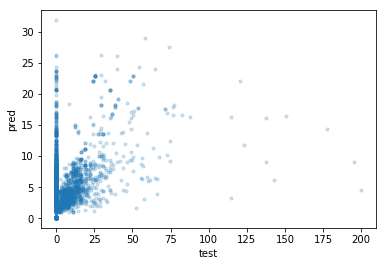

In [80]:
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test).reshape(y_test.shape[0], 1)  
print(rfr.oob_score_)

score = np.dot((pred - y_test).T, (pred - y_test))  
print("===Euclidean Distance===")  
print(score[0, 0])  

a = pd.DataFrame(np.concatenate((np.array(y_test), pred), axis=1))  
a.columns = ["test", "pred"]  

a.plot.scatter(x = 'test', y = 'pred', s = 10, alpha = 0.2)  
plt.show()  

> order = 1  
14368734.289, 0.557460340944    
11113583.7032, new

In [58]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0
                              ,class_weight = {1: (len(click) + len(basket))/len(order), 0: 1.0})

In [65]:
print("===Decision Tree===")
processing(tree)

===Decision Tree===
training down
Misclassified samples: 1944
Accuracy : 0.43
Accuracy (sklearn): 0.43
=confusion matrix=
[[ 210 1934]
 [  10 1240]]


## ensemble

In [67]:
from sklearn.ensemble import BaggingClassifier  
bc = BaggingClassifier(base_estimator = tree,  
                       n_estimators = 10,  
                       max_samples = 1.0,  
                       max_features = 1.0,  
                       bootstrap = True,  
                       bootstrap_features = False,  
                       oob_score = False,  
                       warm_start = False,  
                       n_jobs = 1,  
                       random_state = None,  
                       verbose = 0)    

In [68]:
print("===Bagging===")
processing(bc)

===Bagging===


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training down
Misclassified samples: 1934
Accuracy : 0.43
Accuracy (sklearn): 0.43
==confusion matrix==
[[ 222 1922]
 [  12 1238]]


In [69]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(base_estimator = tree,
                         n_estimators=50,
                         learning_rate=1.0,
                         algorithm='SAMME.R',
                         random_state=None)

In [70]:
print("===AdaBoost===")
processing(abc)

===AdaBoost===


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training down
Misclassified samples: 1656
Accuracy : 0.51
Accuracy (sklearn): 0.51
==confusion matrix==
[[ 712 1432]
 [ 224 1026]]
